
=== Running experiments on Function1 ===
  • Combination: FPS + Truncation
  • Combination: FPS + Tournament
  • Combination: RBS + Truncation
  • Combination: RBS + Tournament
  • Combination: Tournament + Truncation
  • Combination: Tournament + Tournament
  • Combination: Roulette + Truncation
  • Combination: Roulette + Tournament


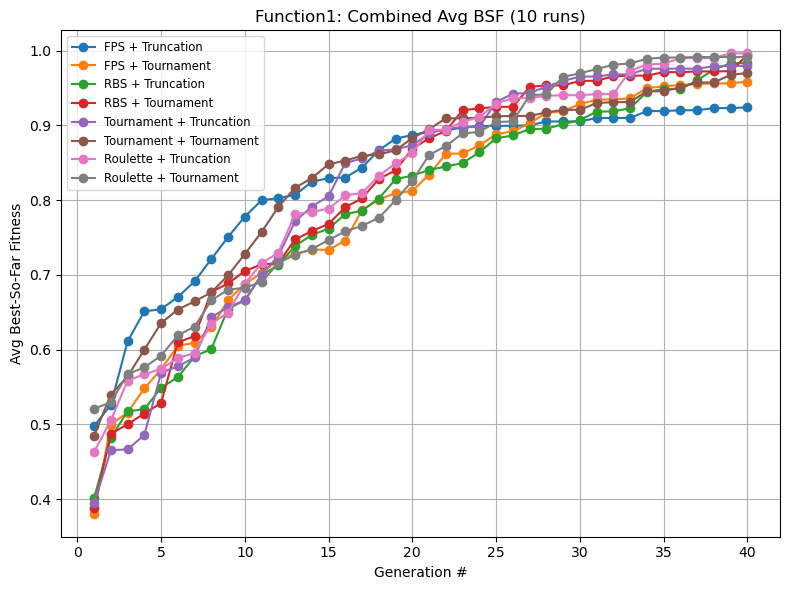

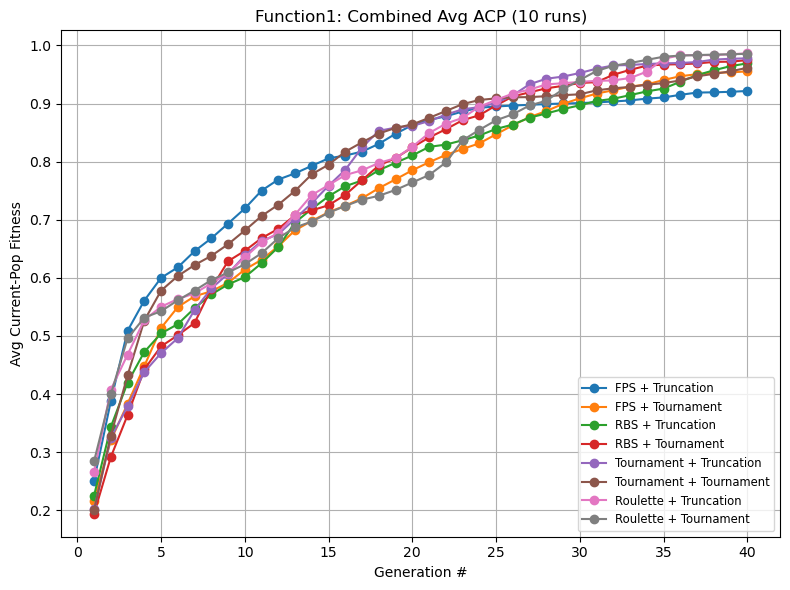

  • Exported CSV: C:\Users\pc\Downloads\Function1_FPS_+_Truncation_BSF.csv
  • Exported JSON: C:\Users\pc\Downloads\Function1_FPS_+_Truncation_BSF.json

=== Running experiments on Function2 ===
  • Combination: FPS + Truncation
  • Combination: FPS + Tournament
  • Combination: RBS + Truncation
  • Combination: RBS + Tournament
  • Combination: Tournament + Truncation
  • Combination: Tournament + Tournament
  • Combination: Roulette + Truncation
  • Combination: Roulette + Tournament


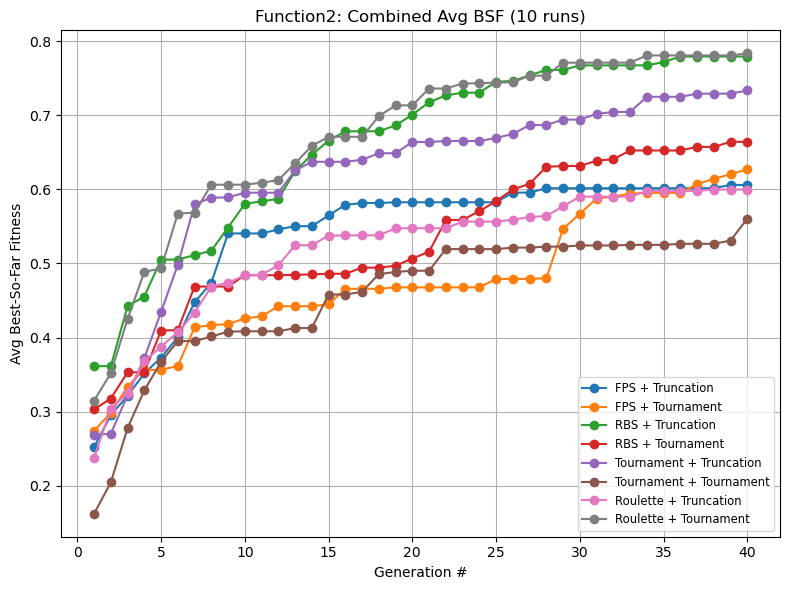

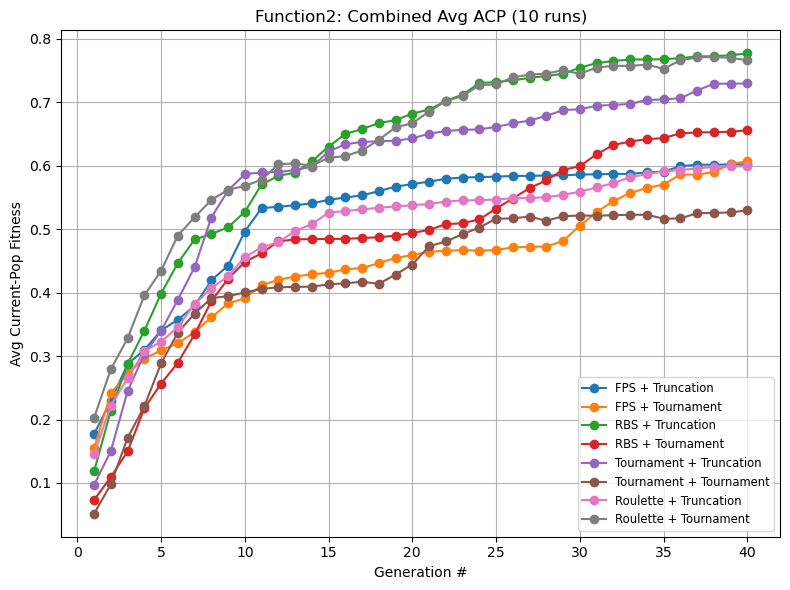

  • Exported CSV: C:\Users\pc\Downloads\Function2_FPS_+_Truncation_BSF.csv
  • Exported JSON: C:\Users\pc\Downloads\Function2_FPS_+_Truncation_BSF.json


In [2]:
import numpy as np
import random
import csv
import json
import os
from io import StringIO
import matplotlib.pyplot as plt

# ============================================
# Objective Functions
# ============================================

def func1(x, y):
    """
    Function 1: f(x, y) = x^2 + y^2
    Domain: -5 <= x, y <= 5
    """
    return x**2 + y**2

def func2(x, y):
    """
    Function 2: f(x, y) = 100*(x^2 - y)^2 + (1 - x)^2
    Domain: -2 <= x <= 2, -1 <= y <= 3
    """
    return 100.0 * (x**2 - y)**2 + (1.0 - x)**2

# ============================================
# Fitness Transformation (for minimization → maximization)
# ============================================

def fitness_from_objective(f_vals):
    """
    Convert objective values (to be minimized) into fitness values (to be maximized).
    We use fitness = 1/(1 + f), so fitness ∈ (0, 1] for f ≥ 0.
    """
    return 1.0 / (1.0 + f_vals)

# ============================================
# Population Initialization
# ============================================

def initialize_population(pop_size, domain):
    """
    Initialize 'pop_size' individuals uniformly at random within the given domain.
    Args:
        pop_size: int, number of individuals.
        domain: tuple of bounds ((x_min, x_max), (y_min, y_max)).
    Returns:
        population: NumPy array of shape (pop_size, 2), each row is [x, y].
    """
    (x_min, x_max), (y_min, y_max) = domain
    xs = np.random.uniform(x_min, x_max, size=pop_size)
    ys = np.random.uniform(y_min, y_max, size=pop_size)
    return np.column_stack((xs, ys))

# ============================================
# Parent‐Selection Operators
# ============================================

def fps_selection(population, fitnesses, num_parents):
    """
    Fitness‐Proportionate Selection (Roulette Wheel).
    Returns 'num_parents' individuals chosen (with replacement) from 'population'.
    """
    total_fit = np.sum(fitnesses)
    if total_fit <= 0:
        # Degenerate case: all fitnesses = 0 → pick uniformly at random
        idxs = np.random.choice(len(population), size=num_parents, replace=True)
        return population[idxs]
    probs = fitnesses / total_fit
    idxs = np.random.choice(len(population), size=num_parents, replace=True, p=probs)
    return population[idxs]

def rbs_selection(population, fitnesses, num_parents):
    """
    Rank‐Based Selection.
    Sort population by fitness (descending), assign linear rank‐based probabilities.
    """
    N = len(population)
    sorted_idx = np.argsort(-fitnesses)  # descending
    ranks = np.empty(N, dtype=int)
    ranks[sorted_idx] = np.arange(1, N + 1)  # best gets rank=1
    # Linear rank probabilities: p_i = (2*(N + 1 - rank_i)) / (N*(N + 1))
    probs = (2.0 * (N + 1 - ranks)) / (N * (N + 1))
    probs = probs / np.sum(probs)  # normalize
    idxs = np.random.choice(N, size=num_parents, replace=True, p=probs)
    return population[idxs]

def tournament_selection(population, fitnesses, num_parents, tournament_size=2):
    """
    Binary Tournament Selection (tournament_size=2).
    Each time, pick 'tournament_size' individuals at random, return the one with max fitness.
    """
    N = len(population)
    selected = []
    for _ in range(num_parents):
        contestants = np.random.choice(N, size=tournament_size, replace=False)
        winner = contestants[np.argmax(fitnesses[contestants])]
        selected.append(population[winner])
    return np.array(selected)

def roulette_selection(population, fitnesses, num_parents):
    """
    Alias for fps_selection (just to allow naming consistency).
    """
    return fps_selection(population, fitnesses, num_parents)

# ============================================
# Crossover and Mutation (Real‐Coded)
# ============================================

def uniform_crossover(parent1, parent2):
    """
    Uniform crossover for two parent vectors (size=2).
    For each gene (x or y), flip a fair coin to decide which parent's gene to take.
    """
    child = np.empty_like(parent1)
    for i in range(2):
        child[i] = parent1[i] if random.random() < 0.5 else parent2[i]
    return child

def arithmetic_crossover(parent1, parent2):
    """
    Arithmetic crossover: offspring = α*p1 + (1 - α)*p2 (for both genes).
    """
    α = random.random()
    child = α * parent1 + (1 - α) * parent2
    return child

def blend_crossover(parent1, parent2, α=0.3):
    """
    Blend (BLX‐α) crossover: offspring each gene from a uniform interval beyond parents.
    """
    child = np.empty_like(parent1)
    for i in range(2):
        low = min(parent1[i], parent2[i]) - α * abs(parent1[i] - parent2[i])
        high = max(parent1[i], parent2[i]) + α * abs(parent1[i] - parent2[i])
        child[i] = random.uniform(low, high)
    return child

def mutate(individual, domain, mutation_prob=0.1, mutation_step=0.25, mutation_type='gaussian', current_gen=None, total_gens=None):
    """
    Mutate a real‐valued individual [x, y].
    mutation_type ∈ {'gaussian', 'uniform', 'creep'}.
    - gaussian: add N(0, 0.1) to each gene
    - uniform: add Uniform(−δ, δ) to each gene (δ = mutation_step)
    - creep: add Uniform(−step, +step), where step shrinks over generations
    After mutation, clamp gene to within 'domain'.
    """
    (x_min, x_max), (y_min, y_max) = domain
    new = individual.copy()
    if mutation_type == 'gaussian':
        new[0] += random.gauss(0, mutation_step)
        new[1] += random.gauss(0, mutation_step)
    elif mutation_type == 'uniform':
        new[0] += random.uniform(-mutation_step, mutation_step)
        new[1] += random.uniform(-mutation_step, mutation_step)
    elif mutation_type == 'creep' and (current_gen is not None and total_gens is not None):
        scale = (1 - current_gen / total_gens)
        step = mutation_step * scale
        new[0] += random.uniform(-step, step)
        new[1] += random.uniform(-step, step)
    # Clamp to domain
    new[0] = np.clip(new[0], x_min, x_max)
    new[1] = np.clip(new[1], y_min, y_max)
    return new

# ============================================
# Survival Selection (Truncation & Tournament)
# ============================================

def truncation_selection(combined_pop, combined_fitnesses, survivors_count):
    """
    Truncation: pick the top 'survivors_count' individuals by fitness.
    """
    sorted_idx = np.argsort(-combined_fitnesses)  # descending
    return combined_pop[sorted_idx[:survivors_count]]

def survival_tournament_selection(combined_pop, combined_fitnesses, survivors_count):
    """
    Binary Tournament Survival Selection without replacement.
    Assumes combined_pop size = 2 * survivors_count.
    """
    N = len(combined_pop)
    assert N == 2 * survivors_count, "Combined pop size must be 2 * survivors_count."
    idxs = np.arange(N)
    np.random.shuffle(idxs)
    survivors = []
    for i in range(0, N, 2):
        i1, i2 = idxs[i], idxs[i + 1]
        survivors.append(combined_pop[i1] if combined_fitnesses[i1] >= combined_fitnesses[i2] else combined_pop[i2])
    return np.array(survivors)

# ============================================
# One GA Run (Single Combination of Selection Schemes)
# ============================================

def run_one_ga_run(
    objective_fn,
    domain,
    pop_size,
    num_generations,
    parent_selection_method,
    survival_selection_method,
    crossover_type='uniform',
    mutation_type='gaussian',
    mutation_prob=0.1,
    mutation_step=0.25
):
    """
    Run a single GA run for 'num_generations' on 'objective_fn' with given selection schemes.
    Returns:
        bsf_history: list of length num_generations → best‐so‐far fitness at each generation
        avg_history: list of length num_generations → average fitness of current population each gen
    """
    # 1. Initialize population
    pop = initialize_population(pop_size, domain)  # shape (pop_size, 2)
    # 2. Evaluate initial population
    obj_vals = np.array([objective_fn(ind[0], ind[1]) for ind in pop])
    fitnesses = fitness_from_objective(obj_vals)
    # 3. Initialize best‐so‐far
    best_so_far = np.max(fitnesses)
    bsf_history = []
    avg_history = []

    for gen in range(num_generations):
        # --- Parent Selection ---
        if parent_selection_method == 'FPS':
            parents = fps_selection(pop, fitnesses, pop_size)
        elif parent_selection_method == 'RBS':
            parents = rbs_selection(pop, fitnesses, pop_size)
        elif parent_selection_method == 'Tournament':
            parents = tournament_selection(pop, fitnesses, pop_size, tournament_size=2)
        elif parent_selection_method == 'Roulette':
            parents = roulette_selection(pop, fitnesses, pop_size)
        else:
            raise ValueError(f"Unknown parent selection method '{parent_selection_method}'")

        # --- Crossover & Mutation to produce 'pop_size' offspring ---
        offspring = np.zeros_like(parents)
        for i in range(pop_size):
            # Choose two parents (with replacement)
            p1_idx, p2_idx = np.random.choice(pop_size, size=2, replace=True)
            p1, p2 = parents[p1_idx], parents[p2_idx]

            # Crossover
            if crossover_type == 'uniform':
                child = uniform_crossover(p1, p2)
            elif crossover_type == 'arithmetic':
                child = arithmetic_crossover(p1, p2)
            elif crossover_type == 'blend':
                child = blend_crossover(p1, p2, α=0.3)
            else:
                raise ValueError(f"Unknown crossover type '{crossover_type}'")

            # Mutation (with probability mutation_prob per individual)
            if random.random() < mutation_prob:
                child = mutate(child, domain, mutation_prob, mutation_step, mutation_type, current_gen=gen, total_gens=num_generations)

            offspring[i] = child

        # --- Evaluate Offspring ---
        obj_off = np.array([objective_fn(ind[0], ind[1]) for ind in offspring])
        fit_off = fitness_from_objective(obj_off)

        # --- Combine Parents and Offspring ---
        combined_pop = np.vstack((pop, offspring))
        combined_fit = np.concatenate((fitnesses, fit_off))

        # --- Survival Selection ---
        if survival_selection_method == 'Truncation':
            pop = truncation_selection(combined_pop, combined_fit, pop_size)
        elif survival_selection_method == 'Tournament':
            # expects combined size == 2 * pop_size
            pop = survival_tournament_selection(combined_pop, combined_fit, pop_size)
        else:
            raise ValueError(f"Unknown survival selection method '{survival_selection_method}'")

        # 4. Evaluate new population
        obj_vals = np.array([objective_fn(ind[0], ind[1]) for ind in pop])
        fitnesses = fitness_from_objective(obj_vals)

        # 5. Record metrics
        current_best = np.max(fitnesses)
        best_so_far = max(best_so_far, current_best)
        bsf_history.append(best_so_far)
        avg_history.append(np.mean(fitnesses))

    return bsf_history, avg_history

# ============================================
# Experiment Runner (Multiple Runs + Averaging)
# ============================================

def run_experiment(
    objective_fn,
    domain,
    pop_size=10,
    num_generations=40,
    parent_selection_method='FPS',
    survival_selection_method='Truncation',
    crossover_type='uniform',
    mutation_type='gaussian',
    mutation_prob=0.1,
    mutation_step=0.25,
    num_runs=10
):
    """
    Run 'num_runs' independent GA runs and compute average BSF and ACP per generation.
    Returns:
        avg_bsf: length num_generations → average best‐so‐far across runs
        avg_acp: length num_generations → average of current‐pop fitness across runs
    """
    all_bsf = np.zeros((num_runs, num_generations))
    all_acp = np.zeros((num_runs, num_generations))

    for run_idx in range(num_runs):
        bsf_hist, avg_hist = run_one_ga_run(
            objective_fn=objective_fn,
            domain=domain,
            pop_size=pop_size,
            num_generations=num_generations,
            parent_selection_method=parent_selection_method,
            survival_selection_method=survival_selection_method,
            crossover_type=crossover_type,
            mutation_type=mutation_type,
            mutation_prob=mutation_prob,
            mutation_step=mutation_step
        )
        all_bsf[run_idx, :] = bsf_hist
        all_acp[run_idx, :] = avg_hist

    avg_bsf = np.mean(all_bsf, axis=0)
    avg_acp = np.mean(all_acp, axis=0)
    return avg_bsf, avg_acp

# ============================================
# Export Functions (CSV & JSON)
# ============================================

def export_results_to_csv(run_data, average, filename="ga_results.csv"):
    """
    Export GA results to a CSV file.
    run_data: List of lists. run_data[r][g] = best‐so‐far in run r at generation g.
    average: List of length num_generations.
    """
    num_runs = len(run_data)
    num_gens = len(average)
    header = ["Generation"] + [f"Run_{i+1}" for i in range(num_runs)] + ["Average"]
    rows = []
    for g in range(num_gens):
        row = [g + 1]
        for r in range(num_runs):
            row.append(run_data[r][g])
        row.append(average[g])
        rows.append(row)

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        writer.writerows(rows)

    return os.path.abspath(filename)

def export_results_to_json(run_data, average, filename="ga_results.json"):
    """
    Export GA results to a JSON file.
    """
    num_runs = len(run_data)
    num_gens = len(average)
    structured = {
        "num_generations": num_gens,
        "num_runs": num_runs,
        "data_by_generation": []
    }
    for g in range(num_gens):
        structured["data_by_generation"].append({
            "generation": g + 1,
            "run_results": [run_data[r][g] for r in range(num_runs)],
            "average": average[g]
        })
    with open(filename, 'w') as jf:
        json.dump(structured, jf, indent=2)
    return os.path.abspath(filename)

# ============================================
# Plotting Utilities
# ============================================

def plot_metric(metric_dict, ylabel, title):
    """
    Plot multiple metrics over generations in a single figure.
    metric_dict: dict mapping label → array/list of length num_generations
    """
    gens = np.arange(1, len(next(iter(metric_dict.values()))) + 1)
    plt.figure(figsize=(8, 6))
    for label, values in metric_dict.items():
        plt.plot(gens, values, marker='o', label=label)
    plt.xlabel('Generation #')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ============================================
# Main: Running Experiments on Both Functions
# ============================================

if __name__ == "__main__":
    # For reproducibility
    np.random.seed(42)
    random.seed(42)

    # Define problems
    problems = {
        'Function1': {
            'fn': func1,
            'domain': ((-5.0, 5.0), (-5.0, 5.0))
        },
        'Function2': {
            'fn': func2,
            'domain': ((-2.0, 2.0), (-1.0, 3.0))
        }
    }

    parent_methods = ['FPS', 'RBS', 'Tournament', 'Roulette']
    survival_methods = ['Truncation', 'Tournament']
    crossover_types = ['uniform', 'arithmetic', 'blend']
    mutation_types = ['gaussian', 'uniform', 'creep']

    pop_size = 10
    num_generations = 40
    num_runs = 10
    mutation_prob = 0.1
    mutation_step = 0.25

    # Loop over each problem
    for prob_name, prob_data in problems.items():
        objective_fn = prob_data['fn']
        domain = prob_data['domain']

        print(f"\n=== Running experiments on {prob_name} ===")

        # Dictionaries to store average BSF/ACP for each combo
        combined_bsf = {}
        combined_acp = {}

        # We’ll keep run_data separately per combination if we want to export
        all_run_data = {}

        # Run each combination of parent & survival selection (keeping crossover & mutation fixed for simplicity)
        for p_sel in parent_methods:
            for s_sel in survival_methods:
                combo_label = f"{p_sel} + {s_sel}"
                print(f"  • Combination: {combo_label}")

                # Run the experiment
                avg_bsf, avg_acp = run_experiment(
                    objective_fn=objective_fn,
                    domain=domain,
                    pop_size=pop_size,
                    num_generations=num_generations,
                    parent_selection_method=p_sel,
                    survival_selection_method=s_sel,
                    crossover_type='uniform',        # you could vary this too
                    mutation_type='gaussian',       # and this as well
                    mutation_prob=mutation_prob,
                    mutation_step=mutation_step,
                    num_runs=num_runs
                )

                # Store averages for plotting
                combined_bsf[combo_label] = avg_bsf
                combined_acp[combo_label] = avg_acp

                # (Optional) store per‐run data if you want to export each combination separately
                # For brevity, we only exported averages here; if needed, modify run_experiment to return per‐run histories too.

        # Plot combined Best‐So‐Far curves
        plot_metric(
            combined_bsf,
            ylabel='Avg Best‐So‐Far Fitness',
            title=f"{prob_name}: Combined Avg BSF (10 runs)"
        )

        # Plot combined Current‐Population curves
        plot_metric(
            combined_acp,
            ylabel='Avg Current‐Pop Fitness',
            title=f"{prob_name}: Combined Avg ACP (10 runs)"
        )

        # (Optional) Export the average BSF of one chosen combination to CSV/JSON:
        # Example: pick the first combination in combined_bsf
        first_combo = next(iter(combined_bsf))
        # Suppose we want to save “avg_bsf” of that combo across 10 runs:
        # But since run_experiment only returns averages, not per‐run data, we only export the average.
        avg_to_export = combined_bsf[first_combo]
        # Create dummy run_data (all runs identical = average) if you want a CSV with runs columns.
        dummy_run_data = [list(avg_to_export) for _ in range(num_runs)]
        csv_path = export_results_to_csv(dummy_run_data, avg_to_export, filename=f"{prob_name}_{first_combo.replace(' ', '_')}_BSF.csv")
        json_path = export_results_to_json(dummy_run_data, avg_to_export, filename=f"{prob_name}_{first_combo.replace(' ', '_')}_BSF.json")
        print(f"  • Exported CSV: {csv_path}")
        print(f"  • Exported JSON: {json_path}")
